In [20]:
import torch
import torch.nn as nn
import os
import utils

In [21]:
args = {}
args["data_dir"] = "/Volumes/T7 Shield/Datasets/Flickr30"

args["output_directory"] = "plots"

plots_path = os.path.join(
    args["output_directory"])
if not os.path.exists(plots_path):
    os.makedirs(plots_path)

In [22]:
from transformers import AutoImageProcessor

dataloaders, dataset_sizes = utils.get_dataloaders(
    args["data_dir"], image_size=224, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225], batch_size=4, num_workers=8,
)

In [23]:
inputs, labels = next(iter(dataloaders['train']))
inputs.size(), labels

(torch.Size([4, 3, 224, 224]),
 ('Two crazy looking girls are about to jump into a lake.',
  'A man in a black shirt and shorts is kneeling in the shade of a building.',
  'Two boys, one in a red shirt, the other in a white shirt are splashing around in the water.',
  'A man wearing sunglasses, kneepads and shorts is jogging.'))

In [24]:
from transformers import AutoModel

# model = AutoModel.from_pretrained('facebook/dinov2-small')
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
outputs = model(inputs)

Using cache found in /Users/rishitoshsingh/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth" to /Users/rishitoshsingh/.cache/torch/hub/checkpoints/dinov2_vits14_reg4_pretrain.pth
100%|██████████| 84.2M/84.2M [00:03<00:00, 23.8MB/s]


In [25]:
outputs.shape

torch.Size([4, 384])

In [26]:
output = model.forward_features(inputs)
features = output["x_norm_patchtokens"]
features.shape

torch.Size([4, 256, 384])

In [27]:
features = features.reshape(-1, features.shape[-1])
features

tensor([[ 1.3355,  0.5491,  3.6870,  ...,  0.7630, -0.6606, -0.3941],
        [ 0.5136, -0.2575,  3.6562,  ...,  0.0591, -0.3146, -0.7782],
        [-0.0747, -1.0104,  4.4765,  ...,  0.1737, -0.3834, -0.5925],
        ...,
        [-0.6544,  0.3224,  2.1712,  ...,  0.1451, -0.1394, -2.4337],
        [ 0.0318,  1.1038,  3.8418,  ..., -0.9725, -0.8790, -2.4368],
        [-1.5372,  2.4841,  2.4776,  ..., -0.2327,  0.0679, -1.1562]],
       grad_fn=<UnsafeViewBackward0>)

In [28]:
features = features.detach().numpy()

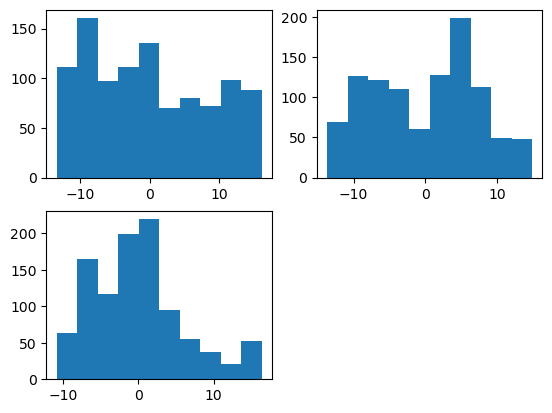

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning

pca = PCA(n_components=3)
# pca.fit(features.detach().numpy())
pca.fit(features)
pca_features = pca.transform(features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

In [30]:
pca_features.shape

(1024, 3)

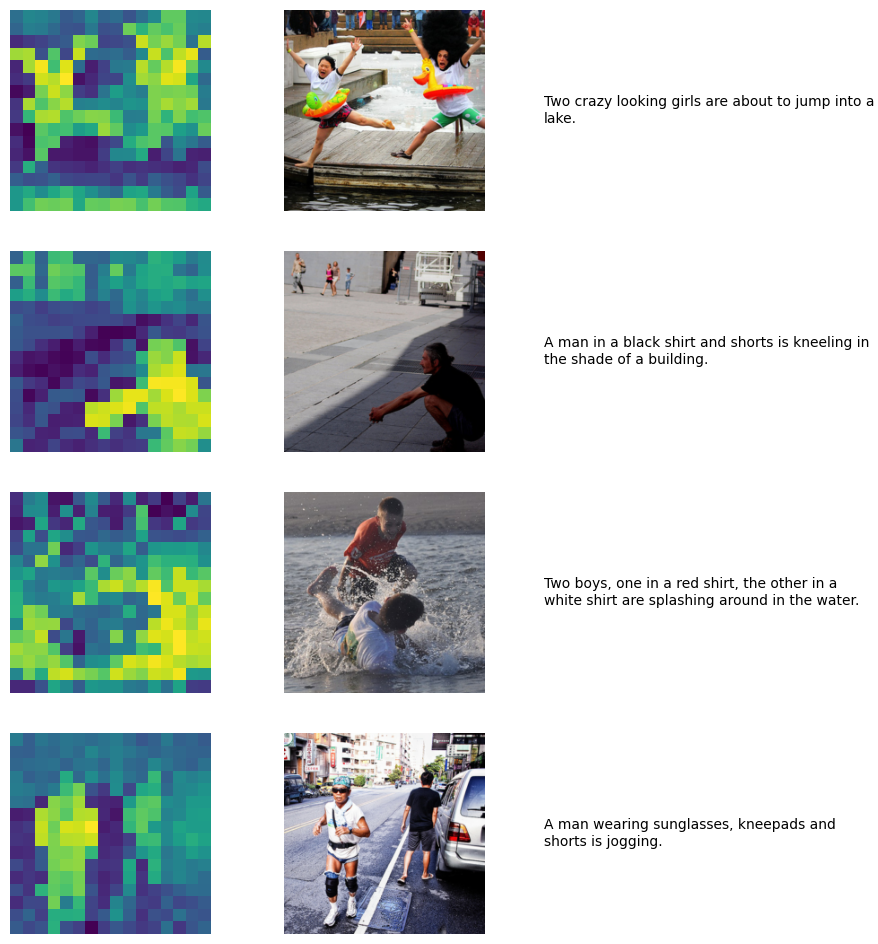

In [52]:

# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
# pca_features = sklearn.processing.minmax_scale(pca_features)

fig, axs = plt.subplots(4, 3, figsize=(10, 12))

for i in range(4):
    axs[i, 0].imshow(pca_features[i*256: (i+1)*256, 0].reshape(16, 16))
    axs[i, 0].axison = False
    axs[i, 1].imshow(utils.imagenet_inverse_normalize(inputs[i]).permute(1, 2, 0))
    axs[i, 1].axison = False
    axs[i, 2].text(0, 0.5, labels[i], wrap=True, ha='left', va='center', fontsize=10)
    axs[i, 2].axis('off')
    # plt.subplot(2, 2, i+1)
    # plt.imshow(pca_features[i*256: (i+1)*256, 0].reshape(16,16))

plt.show()

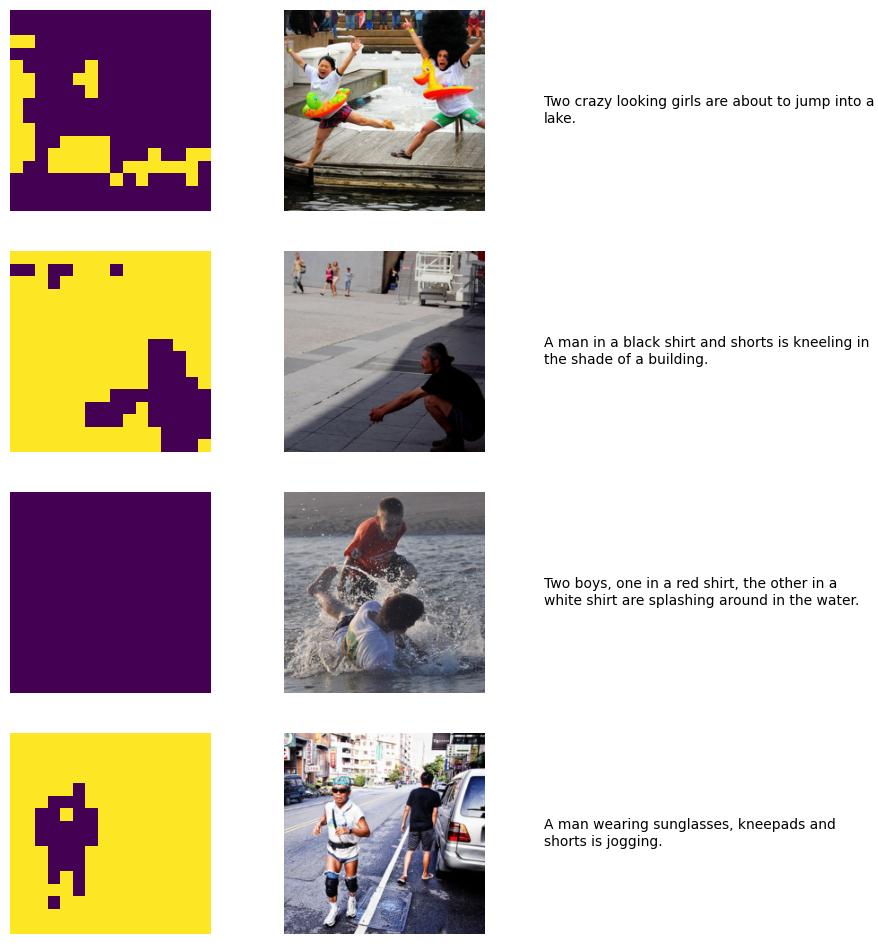

In [53]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] < 0.4  # from first histogram
pca_features_fg = ~pca_features_bg

fig, axs = plt.subplots(4, 3, figsize=(10, 12))

# plot the pca_features_bg
for i in range(4):
    axs[i, 0].imshow(pca_features_bg[i * 256: (i+1) * 256].reshape(16, 16))
    axs[i, 0].axison = False
    axs[i, 1].imshow(utils.imagenet_inverse_normalize(inputs[i]).permute(1, 2, 0))
    axs[i, 1].axison = False
    axs[i, 2].text(0, 0.5, labels[i], wrap=True, ha='left', va='center', fontsize=10)
    axs[i, 2].axis('off')
plt.show()

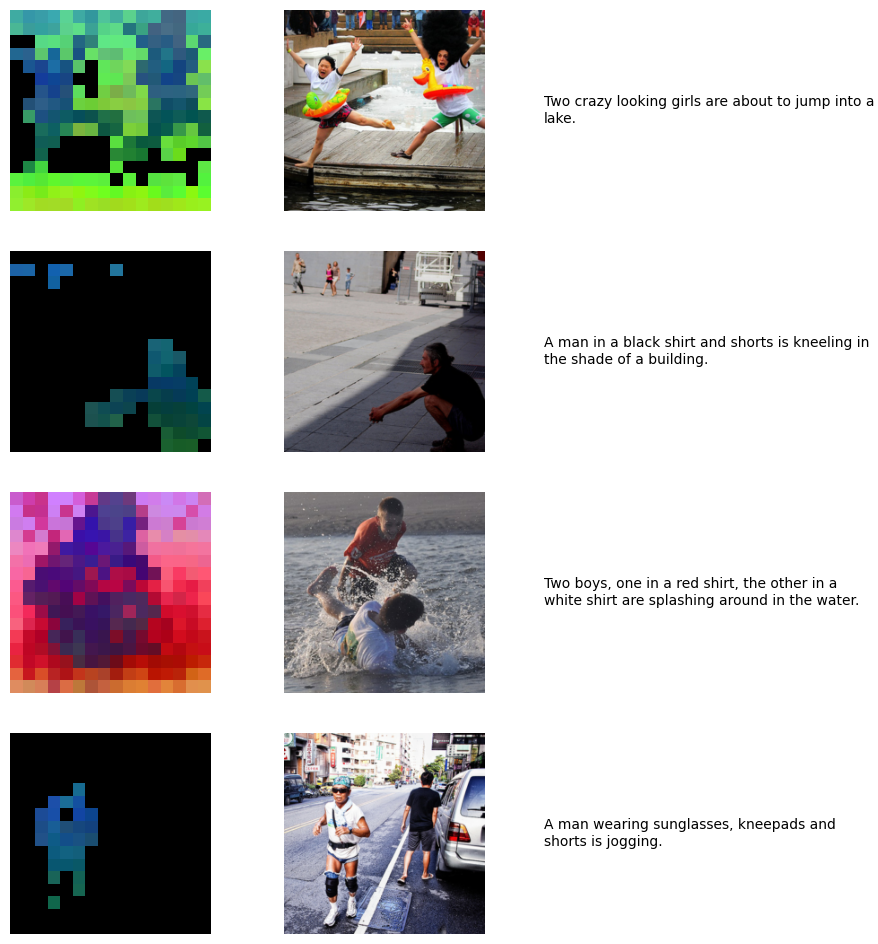

In [54]:
# 2nd PCA for only foreground patches
pca.fit(features[pca_features_fg])
pca_features_left = pca.transform(features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (
        pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, 16, 16, 3)
fig, axs = plt.subplots(4, 3, figsize=(10, 12))

for i in range(4):
    axs[i, 0].imshow(pca_features_rgb[i])
    axs[i, 0].axison = False
    axs[i, 1].imshow(utils.imagenet_inverse_normalize(inputs[i]).permute(1, 2, 0))
    axs[i, 1].axison = False
    axs[i, 2].text(0, 0.5, labels[i], wrap=True, ha='left', va='center', fontsize=10)
    axs[i, 2].axis('off')
plt.show()

In [55]:
model

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n